In [1]:
import torch

print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

12.8
NVIDIA GeForce RTX 4060 Laptop GPU


In [2]:
allocated_bytes = torch.cuda.memory_allocated('cuda')
allocated_mb = allocated_bytes / (1024 * 1024)

reserved_bytes = torch.cuda.memory_reserved('cuda')
reserved_mb = reserved_bytes / (1024 * 1024)

print("\n--- VRAM USAGE REPORT ---")
print(f"Memory Allocated: {allocated_mb:.2f} MB")
print(f"Memory Reserved:  {reserved_mb:.2f} MB")
print("-------------------------\n")


--- VRAM USAGE REPORT ---
Memory Allocated: 0.00 MB
Memory Reserved:  0.00 MB
-------------------------



In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

training_pipeline = A.Compose([

    A.Resize(height=224, width=224),
    A.RandomCrop(height=180, width=180, p=1.0),
    A.Resize(height=224, width=224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.4),

    A.RandomBrightnessContrast(brightness_limit=(-0.3, 0.3), contrast_limit=(-0.2, 0.2), p=0.4),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.4),

    A.OneOf([
        A.GaussNoise(std_range=(0.1, 0.2), per_channel=True, p=0.4),
        A.RandomRain(slant_range=(-15, 15), drop_length=15, drop_width=1, rain_type="default", blur_value=7, p=0.4),
        A.CoarseDropout(num_holes_range=(1, 3), hole_height_range=(0.1, 0.25), hole_width_range=(0.1, 0.25), fill=0, p=0.4)
    ], p=0.5),

    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

validation_pipeline = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

basic_pipeline = A.Compose([
    A.Resize(height=224, width=224),
    A.HorizontalFlip(p=0.6),
    A.VerticalFlip(p=0.6),
    A.Rotate(limit=(-45,45), p=0.7),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [4]:
import cv2
from torchvision import datasets

class CustomDataset(datasets.ImageFolder):

    def __getitem__(self, index):

        path, target = self.samples[index]

        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, target

    def __len__(self):
        return len(self.samples)

<h2>MobileNetV2</h2>

In [5]:
import torchvision.models as models
import torch.nn as nn

class PestClassifierMobileNetV2(nn.Module):

    def __init__(self, num_classes):
        super(PestClassifierMobileNetV2, self).__init__()

        # get model
        self.base_model = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V2')

        # Froze feature extraction layer to retain weights.
        for params in self.base_model.parameters():
            params.requires_grad = False

        # get number of features
        num_filters = self.base_model.classifier[1].in_features

        # Hyperparameter tuning: new layer for 6 rice pests.
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=0.4, inplace=True),
            nn.Linear(num_filters, num_classes),
        )

    # Forward propagation
    def forward(self, x):

       features = self.base_model.features(x)

       features = F.adaptive_avg_pool2d(features, output_size=(1, 1)).reshape(features.shape[0], -1)

       features = self.base_model.classifier(features)

       return features

    def unfreeze_layer(self, layer):

        if not (1 <= layer <= len(self.base_model.features)):
            print(f"Error: Invalid layer index {layer}.")
            return

        # Corrected print statement
        print(f"\nUnfreezing feature layer at index: -{layer}")

        for param in self.base_model.features[-layer].parameters():
            param.requires_grad = True


<h2>EfficientNetV2-m</h2>

In [6]:
class PestClassifierEfficientNetV2M(nn.Module):

    def __init__(self, num_classes):
        super(PestClassifierEfficientNetV2M, self).__init__()

        self.base_model = models.efficientnet_v2_m(weights='EfficientNet_V2_M_Weights.IMAGENET1K_V1')

        for params in self.base_model.parameters():
            params.requires_grad = False

        features = self.base_model.classifier[1].in_features

        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(features, num_classes),
        )

    def forward(self, x):

        features = self.base_model.features(x)

        features = self.base_model.avgpool(features)

        features = torch.flatten(features, start_dim=1)

        features = self.base_model.classifier(features)

        return features

    def unfreeze_layer(self, layer):

        if not (1 <= layer <= len(self.base_model.features)):
            print(f"Error: Invalid layer index {layer}.")
            return

        print(f"\nUnfreezing feature layer at index: -{layer}")

        for params in self.base_model.features[-layer].parameters():
            params.requires_grad = True


<h2>EfficientNetV2-s</h2>

In [7]:
class PestClassifierEfficientNetV2S(nn.Module):

    def __init__(self, num_classes):

        super(PestClassifierEfficientNetV2S, self).__init__()

        self.base_model = models.efficientnet_v2_s(weights='EfficientNet_V2_S_Weights.IMAGENET1K_V1')

        for params in self.base_model.parameters():
            params.requires_grad = False

        features = self.base_model.classifier[1].in_features

        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(features, num_classes),
        )

    def forward(self, x):

        features = self.base_model.features(x)

        features = F.adaptive_avg_pool2d(features, output_size=(1,1)).reshape(features.shape[0], -1)

        features = self.base_model.classifier(features)

        return features

    def unfreeze_layer(self, layer):

        if not (1 <= layer <= len(self.base_model.features)):
            print(f"Error: Invalid layer index {layer}.")

        print(f"\nUnfreezing feature layer at index: -{layer}")

        for params in self.base_model.features[-layer].parameters():
            params.requires_grad = True


<h2>ResNet50</h2>

In [8]:
class PestClassifierResNet50(nn.Module):

    def __init__(self, num_classes):

        super(PestClassifierResNet50,self).__init__()

        self.base_model = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V2')

        for params in self.base_model.parameters():
            params.requires_grad = False

        features = self.base_model.fc.in_features

        self.base_model.fc = nn.Sequential(
            nn.Dropout(p=0.4, inplace=True),
            nn.Linear(features, num_classes),
        )

    def forward(self, x):

        return self.base_model(x)

    def unfreeze_layer(self, layer):

        if not (1 <= layer <= 4):
            print('\nLayer out of range. ')

        layer_name = f'layer{layer}'

        layer_to_unfreeze = getattr(self.base_model, layer_name)

        for params in layer_to_unfreeze.parameters():

            params.requires_grad = True


In [ ]:
model = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V2')

print(model)

In [ ]:
model = models.efficientnet_v2_s(weights='EfficientNet_V2_S_Weights.IMAGENET1K_V1')

print(model.parameters)

In [ ]:
model = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V2')

print(model)

In [23]:
import torch
from tqdm import tqdm

def train_and_validate(model, optimizer, criterion, train_dataloader, validation_dataloader, num_epoch, device, scheduler, patience=3, min_delta=0.001):

    train_losses = []
    validation_losses = []
    accuracies = []
    patience_counter = 0
    best_validation_loss=float('inf')
    best_session_accuracy = float('inf')
    stop_early=False
    fully_stop = False

    for epoch in range(num_epoch):
        model.train()
        running_train_loss = 0.0
        train_pbar = tqdm(train_dataloader, desc=f"Train epoch: {epoch+1}")
        for data, labels in train_pbar:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        training_loss = running_train_loss / len(train_dataloader)
        train_losses.append(training_loss)

        model.eval()
        running_eval_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        with torch.no_grad():
            for inputs, labels in tqdm(validation_dataloader, desc=f"Validate Epoch {epoch+1}"):
                inputs, labels = inputs.to(device), labels.to(device)

                logits = model(inputs)
                loss = criterion(logits, labels)
                running_eval_loss += loss.item()
                _, predicted = torch.max(logits.data, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

        validation_loss = running_eval_loss / len(validation_dataloader)
        validation_losses.append(validation_loss)
        accuracy = 100 * correct_predictions / total_samples
        accuracies.append(accuracy)

        scheduler.step(validation_loss)

        current_lr = optimizer.param_groups[0]['lr']
        epoch_summary = f'Epoch {epoch+1}/{num_epoch} |lr: {current_lr}| Train Loss: {training_loss:.4f} | Evaluate Loss: {validation_loss:.4f} | Accuracy: {accuracy:.2f}%'

        if device.type == 'cuda':
            allocated_gb = torch.cuda.memory_allocated() / (1024 ** 3)
            reserved_gb = torch.cuda.memory_reserved() / (1024 ** 3)
            epoch_summary += f' | GPU Memory (Alloc/Reserved): {allocated_gb:.2f}/{reserved_gb:.2f} GB'

        tqdm.write(epoch_summary)

        if validation_loss < best_validation_loss - min_delta:

            patience_counter = 0
            best_validation_loss = validation_loss
            torch.save(model.state_dict(), 'new_models/Resnet50/SResNet50_rice_pest_classificationV4.pt')
        else:
            patience_counter += 1
            tqdm.write(f'No improvement for {patience_counter}/{patience} epochs')

        if  validation_loss >= training_loss:
            tqdm.write(f'Training stopped! Validation loss: {validation_loss:.4f} | Training loss: {training_loss:.4f}')
            fully_stop = True
            break

        if patience_counter >= patience:
            tqdm.write(f'Early stopping triggered after {patience_counter} epochs')
            stop_early = True
            break

    tqdm.write('Session complete')

    return {'train_loss': train_losses, 'validation_loss': validation_losses, 'accuracy': accuracies}, best_session_accuracy, stop_early, fully_stop

<h2>  Saving and plott</h2>

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

def plot_training_result(*results):

    full_training_loss = []
    full_validation_loss = []

    for result in results:
        train_loss = result.get('train_loss', [])
        full_training_loss.extend(train_loss)
        full_validation_loss.extend(result.get('validation_loss', []))

    total_epochs = len(full_training_loss)

    if total_epochs == 0:
        print("No data to plot.")
        return

    epochs = range(1, total_epochs + 1)

    data = {
        'Epoch': epochs,
        'Training Loss': full_training_loss,
        'Validation Loss': full_validation_loss,
    }

    df = pd.DataFrame(data)

    df_long = df.melt(id_vars=['Epoch'], var_name='Loss Type', value_name='Loss')

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_long, x='Epoch', y='Loss', hue='Loss Type', marker='o')

    plt.title('Training and Validation Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_historical_results(file_name):

    data = pd.read_csv(file_name)

    df = pd.DataFrame(data)

    fig, axes = plt.subplots(2, 1, figsize=(10, 12))

    fig.suptitle('Training and Validation Loss Comparison', fontsize=16)

    historical_losses = df.melt(id_vars=['epoch'],value_vars=['train_loss', 'validation_loss'], var_name='Loss Type', value_name='Loss')

    sns.lineplot(data=historical_losses, hue='Loss Type', markers='o' ,x='epoch' , y='Loss', ax=axes[0])

    axes[0].set_title('Training and Validation Loss Comparison')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].grid(True)
    axes[0].legend()

    sns.lineplot(data=df, x='epoch', y='accuracy', color='g', markers='o', ax=axes[1])
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].grid(True)

    plt.tight_layout(rect=(0, 0.03, 1, 0.95))

    plt.show()

def plot_accuracy(*results):

    full_accuracy = []

    for res in results:
        accuracy = res.get('accuracy', [])
        full_accuracy.extend(accuracy)

    total_epochs = len(full_accuracy)

    if total_epochs == 0:
        print("No accuracy data to plot.")
        return

    epochs = range(1, total_epochs + 1)

    plt.figure(figsize=(10, 6))

    plt.plot(epochs, full_accuracy, label='Accuracy', marker='o', color='g')

    plt.title('Accuracy Evaluation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

def save_historical_data(history, filename='training_results/Resnet50/SResNet50_rice_pest_classificationV4.csv'):

    training_loss = history.get('train_loss', [])
    test_loss = history.get('validation_loss', [])
    accuracy = history.get('accuracy', [])

    data_dict = pd.DataFrame({
        'train_loss': training_loss,
        'validation_loss': test_loss,
        'accuracy': accuracy,
    })

    if os.path.exists(filename):
        print("historical data exists! Appending new data.")
        old_data = pd.read_csv(filename)
        combined_data = pd.concat([old_data, data_dict], ignore_index=True)

    else:
        print("Creating new historical data...")
        combined_data = data_dict

    combined_data['epoch'] = range(1, len(combined_data) + 1)

    combined_data = combined_data[['epoch', 'train_loss', 'validation_loss', 'accuracy']]

    combined_data.to_csv(filename, index=False)

    print("Historical data saved successfully!")



In [11]:
from torch.utils.data import DataLoader

train_set = CustomDataset(root='datasets/train', transform=training_pipeline)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
validation_set = CustomDataset(root='datasets/val', transform=validation_pipeline)
validation_loader = DataLoader(validation_set, batch_size=64, shuffle=True)
test_set = CustomDataset(root='datasets/test', transform=validation_pipeline)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

classes = train_set.classes

In [12]:
from torch.optim import lr_scheduler

def incremental_training(model, sessions, criterion, train_dataloader, validation_dataloader, device):

    full_history = []
    best_overall_accuracy = 0.0

    for i, session in enumerate(sessions):
        print(f"\n--- Starting Training Session {i+1}/{len(sessions)} ---")

        epochs = session['epochs']
        lr = session['lr']
        layer_to_unfreeze = session.get('unfreeze_layer', 0)

        if layer_to_unfreeze > 0:
            model.unfreeze_layer(layer_to_unfreeze)

        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=1e-2)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.5, mode='min', patience=2, min_lr=1e-7)

        session_history, session_best_accuracy, stop_early, full_stop = train_and_validate(
            model, optimizer, criterion, train_dataloader, validation_dataloader,
            epochs, device, scheduler
        )

        full_history.append(session_history)
        save_historical_data(session_history)

        if session_best_accuracy > best_overall_accuracy:
            best_overall_accuracy = session_best_accuracy

        if full_stop:
            print("Full stop triggered! possible overfitting in further sessions.")
            break

        if stop_early:
            print("Early stopping triggered. Moving to next session or finishing training.")

    print(f"\n--- Incremental training finished. Best overall accuracy: {best_overall_accuracy:.2f}% ---")
    return full_history


In [24]:
import torch.optim as optim
hardware = torch.device('cuda' if  torch.cuda.is_available() else 'cpu')
classes = 6
criterion = nn.CrossEntropyLoss()

model = PestClassifierResNet50(num_classes=classes).to(hardware)

training_sessions = [

    {'epochs': 15, 'lr': 5e-4, 'unfreeze_layer': 0},

    {'epochs': 25, 'lr': 1e-4, 'unfreeze_layer': 4},

    {'epochs': 35, 'lr': 5e-5, 'unfreeze_layer': 3},

    {'epochs': 45, 'lr': 1e-5, 'unfreeze_layer': 2},

    {'epochs': 55, 'lr': 5e-6, 'unfreeze_layer': 1}q

]

result, accuracies = incremental_training(model=model, sessions=training_sessions, criterion=criterion, train_dataloader=train_loader, validation_dataloader=validation_loader, device=hardware)

plot_training_result(*result)
plot_accuracy(*result)


--- Starting Training Session 1/5 ---


Validate Epoch 1: 100%|██████████| 43/43 [00:12<00:00,  3.58it/s]


Epoch 1/15 |lr: 0.0005| Train Loss: 1.4225 | Evaluate Loss: 1.1899 | Accuracy: 60.58% | GPU Memory (Alloc/Reserved): 0.82/2.23 GB


Validate Epoch 2: 100%|██████████| 43/43 [00:09<00:00,  4.34it/s]


Epoch 2/15 |lr: 0.0005| Train Loss: 1.1519 | Evaluate Loss: 0.9782 | Accuracy: 70.16% | GPU Memory (Alloc/Reserved): 0.82/2.23 GB


Validate Epoch 3: 100%|██████████| 43/43 [00:13<00:00,  3.20it/s]


Epoch 3/15 |lr: 0.0005| Train Loss: 1.0374 | Evaluate Loss: 0.8678 | Accuracy: 73.19% | GPU Memory (Alloc/Reserved): 0.82/2.23 GB


Validate Epoch 4: 100%|██████████| 43/43 [00:19<00:00,  2.25it/s]


Epoch 4/15 |lr: 0.0005| Train Loss: 0.9566 | Evaluate Loss: 0.7857 | Accuracy: 75.48% | GPU Memory (Alloc/Reserved): 0.82/2.23 GB


Validate Epoch 5: 100%|██████████| 43/43 [00:19<00:00,  2.23it/s]


Epoch 5/15 |lr: 0.0005| Train Loss: 0.9105 | Evaluate Loss: 0.7418 | Accuracy: 76.41% | GPU Memory (Alloc/Reserved): 0.82/2.23 GB


Validate Epoch 6: 100%|██████████| 43/43 [00:19<00:00,  2.16it/s]


Epoch 6/15 |lr: 0.0005| Train Loss: 0.8684 | Evaluate Loss: 0.6968 | Accuracy: 78.77% | GPU Memory (Alloc/Reserved): 0.82/2.23 GB


Validate Epoch 7: 100%|██████████| 43/43 [00:20<00:00,  2.06it/s]


Epoch 7/15 |lr: 0.0005| Train Loss: 0.8475 | Evaluate Loss: 0.6531 | Accuracy: 80.36% | GPU Memory (Alloc/Reserved): 0.82/2.23 GB


Validate Epoch 8: 100%|██████████| 43/43 [00:19<00:00,  2.16it/s]


Epoch 8/15 |lr: 0.0005| Train Loss: 0.8148 | Evaluate Loss: 0.6222 | Accuracy: 80.51% | GPU Memory (Alloc/Reserved): 0.82/2.23 GB


Validate Epoch 9: 100%|██████████| 43/43 [00:18<00:00,  2.31it/s]


Epoch 9/15 |lr: 0.0005| Train Loss: 0.7816 | Evaluate Loss: 0.5974 | Accuracy: 80.77% | GPU Memory (Alloc/Reserved): 0.82/2.23 GB


Validate Epoch 10: 100%|██████████| 43/43 [00:18<00:00,  2.28it/s]


Epoch 10/15 |lr: 0.0005| Train Loss: 0.7709 | Evaluate Loss: 0.5801 | Accuracy: 81.95% | GPU Memory (Alloc/Reserved): 0.82/2.23 GB


Validate Epoch 11: 100%|██████████| 43/43 [00:18<00:00,  2.34it/s]


Epoch 11/15 |lr: 0.0005| Train Loss: 0.7666 | Evaluate Loss: 0.5738 | Accuracy: 81.47% | GPU Memory (Alloc/Reserved): 0.82/2.23 GB


Validate Epoch 12: 100%|██████████| 43/43 [00:11<00:00,  3.67it/s]


Epoch 12/15 |lr: 0.0005| Train Loss: 0.7491 | Evaluate Loss: 0.5486 | Accuracy: 82.51% | GPU Memory (Alloc/Reserved): 0.82/2.23 GB


Validate Epoch 13: 100%|██████████| 43/43 [00:09<00:00,  4.32it/s]


Epoch 13/15 |lr: 0.0005| Train Loss: 0.7380 | Evaluate Loss: 0.5448 | Accuracy: 83.03% | GPU Memory (Alloc/Reserved): 0.82/2.23 GB


Validate Epoch 14: 100%|██████████| 43/43 [00:10<00:00,  4.30it/s]


Epoch 14/15 |lr: 0.0005| Train Loss: 0.7350 | Evaluate Loss: 0.5245 | Accuracy: 83.62% | GPU Memory (Alloc/Reserved): 0.82/2.23 GB


Validate Epoch 15: 100%|██████████| 43/43 [00:10<00:00,  4.29it/s]


Epoch 15/15 |lr: 0.0005| Train Loss: 0.7264 | Evaluate Loss: 0.5205 | Accuracy: 83.95% | GPU Memory (Alloc/Reserved): 0.82/2.23 GB
Session complete
Creating new historical data...
Historical data saved successfully!

--- Starting Training Session 2/5 ---


Validate Epoch 1: 100%|██████████| 43/43 [00:10<00:00,  4.23it/s]


Epoch 1/25 |lr: 0.0001| Train Loss: 0.5722 | Evaluate Loss: 0.3111 | Accuracy: 89.28% | GPU Memory (Alloc/Reserved): 0.98/2.23 GB


Validate Epoch 2: 100%|██████████| 43/43 [00:10<00:00,  4.15it/s]


Epoch 2/25 |lr: 0.0001| Train Loss: 0.4409 | Evaluate Loss: 0.2350 | Accuracy: 91.97% | GPU Memory (Alloc/Reserved): 0.98/2.62 GB


Validate Epoch 3: 100%|██████████| 43/43 [00:18<00:00,  2.28it/s]


Epoch 3/25 |lr: 0.0001| Train Loss: 0.3683 | Evaluate Loss: 0.2060 | Accuracy: 92.94% | GPU Memory (Alloc/Reserved): 0.98/2.62 GB


Validate Epoch 4: 100%|██████████| 43/43 [00:19<00:00,  2.19it/s]


Epoch 4/25 |lr: 0.0001| Train Loss: 0.3217 | Evaluate Loss: 0.2025 | Accuracy: 93.34% | GPU Memory (Alloc/Reserved): 0.98/2.62 GB


Validate Epoch 5: 100%|██████████| 43/43 [00:14<00:00,  2.90it/s]


Epoch 5/25 |lr: 0.0001| Train Loss: 0.2831 | Evaluate Loss: 0.1983 | Accuracy: 93.75% | GPU Memory (Alloc/Reserved): 0.98/2.62 GB


Validate Epoch 6: 100%|██████████| 43/43 [00:09<00:00,  4.40it/s]


Epoch 6/25 |lr: 0.0001| Train Loss: 0.2607 | Evaluate Loss: 0.1824 | Accuracy: 94.27% | GPU Memory (Alloc/Reserved): 0.98/2.62 GB


Validate Epoch 7: 100%|██████████| 43/43 [00:09<00:00,  4.32it/s]


Epoch 7/25 |lr: 0.0001| Train Loss: 0.2418 | Evaluate Loss: 0.1741 | Accuracy: 94.38% | GPU Memory (Alloc/Reserved): 0.98/2.62 GB


Validate Epoch 8: 100%|██████████| 43/43 [00:10<00:00,  4.23it/s]


Epoch 8/25 |lr: 0.0001| Train Loss: 0.2114 | Evaluate Loss: 0.1596 | Accuracy: 95.01% | GPU Memory (Alloc/Reserved): 0.98/2.62 GB


Validate Epoch 9: 100%|██████████| 43/43 [00:17<00:00,  2.41it/s]


Epoch 9/25 |lr: 0.0001| Train Loss: 0.2035 | Evaluate Loss: 0.1695 | Accuracy: 94.67% | GPU Memory (Alloc/Reserved): 0.98/2.62 GB
No improvement for 1/3 epochs


Validate Epoch 10: 100%|██████████| 43/43 [00:17<00:00,  2.46it/s]


Epoch 10/25 |lr: 0.0001| Train Loss: 0.1881 | Evaluate Loss: 0.1880 | Accuracy: 94.19% | GPU Memory (Alloc/Reserved): 0.98/2.62 GB
No improvement for 2/3 epochs


Validate Epoch 11: 100%|██████████| 43/43 [00:09<00:00,  4.38it/s]


Epoch 11/25 |lr: 5e-05| Train Loss: 0.1780 | Evaluate Loss: 0.1673 | Accuracy: 95.01% | GPU Memory (Alloc/Reserved): 0.98/2.62 GB
No improvement for 3/3 epochs
Early stopping triggered after 3 epochs
Session complete
historical data exists! Appending new data.
Historical data saved successfully!
Early stopping triggered. Moving to next session or finishing training.

--- Starting Training Session 3/5 ---


Validate Epoch 1: 100%|██████████| 43/43 [00:09<00:00,  4.39it/s]


Epoch 1/35 |lr: 5e-05| Train Loss: 0.1666 | Evaluate Loss: 0.1574 | Accuracy: 95.01% | GPU Memory (Alloc/Reserved): 1.07/4.10 GB


Validate Epoch 2: 100%|██████████| 43/43 [00:09<00:00,  4.38it/s]

Epoch 2/35 |lr: 5e-05| Train Loss: 0.1518 | Evaluate Loss: 0.1625 | Accuracy: 95.01% | GPU Memory (Alloc/Reserved): 1.07/4.10 GB
No improvement for 1/3 epochs
Training stopped! Validation loss: 0.1625 | Training loss: 0.1518
Session complete
historical data exists! Appending new data.
Historical data saved successfully!
Full stop triggered! possible overfitting in further sessions.

--- Incremental training finished. Best overall accuracy: inf% ---


ValueError: too many values to unpack (expected 2)

In [ ]:
plot_historical_results('training_results\EfficientNetV2\SEfficientNetV2-m_rice_pest_classificationV14.csv')

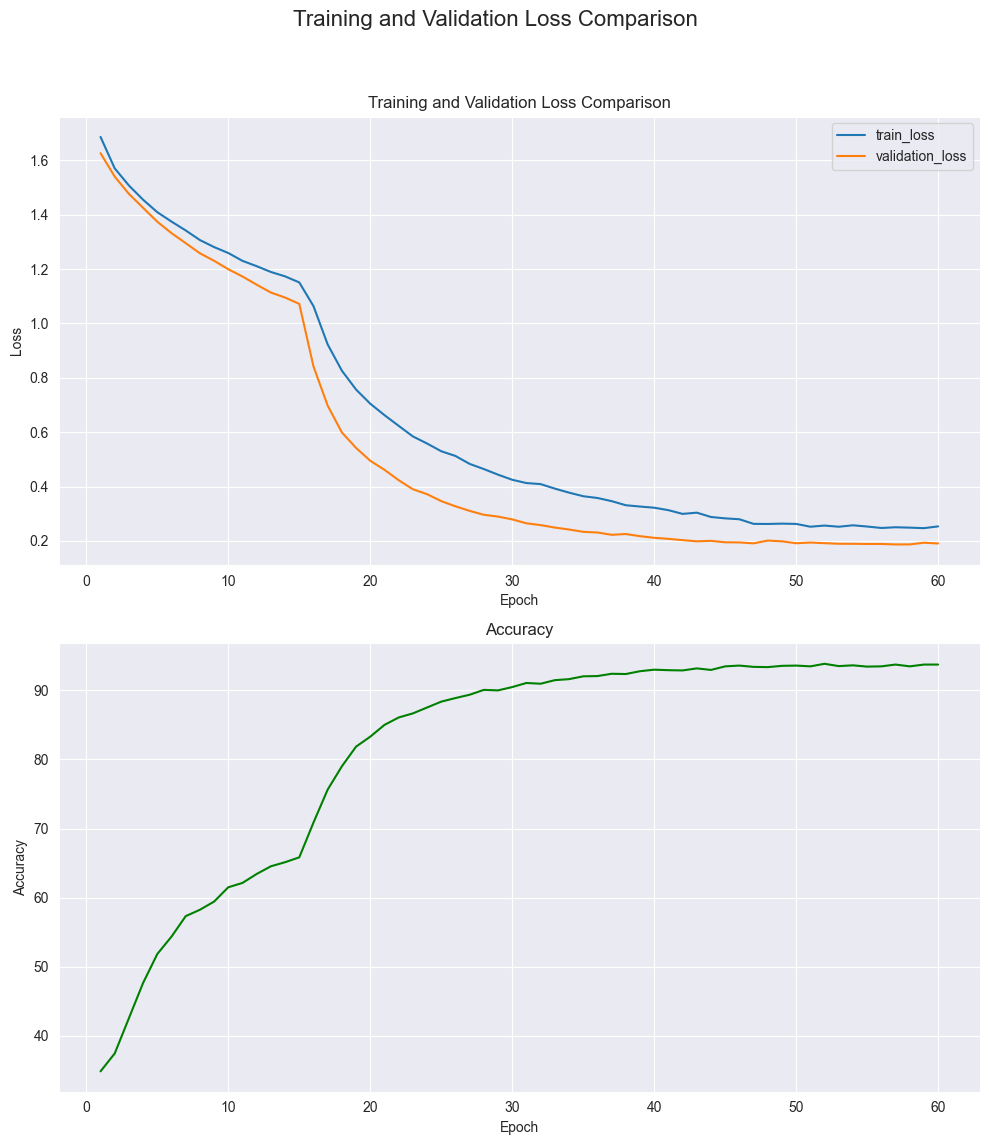

In [18]:
plot_historical_results('training_results/Resnet50/SResNet50_rice_pest_classificationV3.csv')

In [ ]:
import torch.optim as optim

hardware = torch.device('cuda' if  torch.cuda.is_available() else 'cpu')
classes = 6
criterion = nn.CrossEntropyLoss()

model = PestClassifierMobileNetV2(num_classes=classes).to(hardware)

training_sessions = [

    {'epochs': 15, 'lr': 5e-4, 'unfreeze_layer': 0},

    {'epochs': 25, 'lr': 1e-4, 'unfreeze_layer': 1},

    {'epochs': 35, 'lr': 5e-5, 'unfreeze_layer': 2},

    {'epochs': 45, 'lr': 1e-5, 'unfreeze_layer': 3},

    {'epochs': 55, 'lr': 5e-6, 'unfreeze_layer': 4},

    {'epochs': 65, 'lr': 1e-6, 'unfreeze_layer': 5},

    {'epochs': 75, 'lr': 5e-7, 'unfreeze_layer': 6}

]

result, accuracies = incremental_training(model=model, sessions=training_sessions, criterion=criterion, train_dataloader=train_loader, validation_dataloader=validation_loader, device=hardware)

plot_training_result(*result)
plot_accuracy(*result)

In [ ]:
# mobilenet_v2 = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V2')
#
# for num in range(len(mobilenet_v2.features) - 1, -1, -1):
#     print(num)

my_array = [1, 2, 3, 4, 5]

# print(my_array[-5])

for num in range(1, my_array.__len__() + 1):
    print(num)

In [13]:
from PIL import Image
import torch.nn.functional as F

def predict_single_image(model, image_path, classes, transform, device):

    model.to(device)

    model.eval()

    image = Image.open(image_path).convert('RGB')

    image_np = np.array(image)

    augmented = transform(image=image_np)

    image_tensor = augmented['image'].unsqueeze(0).to(device)

    with torch.no_grad():
        result = model(image_tensor)

        probabilities = F.softmax(result, dim=1)

        confidence, predicted_index = torch.max(probabilities, 1)
        predicted_class = classes[predicted_index.item()]
        confidence_score = confidence.item()

    return predicted_class, confidence_score, probabilities.squeeze().cpu().numpy()


In [14]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

def eval_metrics(model, testLoader, classes_names, device):

    model.to(device)
    model.eval()

    total_predictions = []
    true_labels = []

    with torch.no_grad():

        for input, labels in tqdm(testLoader):
            input, labels = input.to(device), labels.to(device)

            output = model(input)
            _, predicted = torch.max(output, 1)

            total_predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())


    y_true = np.array(true_labels)
    y_pred = np.array(total_predictions)

    print('Classification Report')
    report = classification_report(y_true, y_pred, target_names=classes_names)

    print(report)

    print(f"Accuracy: {accuracy_score(y_true, y_pred)*100:.2f}%\n")

    print('Confusion Matrix')

    matrix = confusion_matrix(y_true, y_pred)

    cm_df = pd.DataFrame(matrix, index=classes_names, columns=classes_names)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix (standard)')
    plt.ylabel('Actual pests')
    plt.xlabel('Predicted pests')
    plt.show()

    return y_true, y_pred

def save_evalution_result(total_predictions, true_labels):

    data = pd.DataFrame({
        'True Labels': true_labels,
        'Predicted Labels': total_predictions
    })

    data.to_csv('evalution_result.csv', index=False)


The predicted pest is: green-leafhopper
Confidence: 88.21%
Overall score: [4.7473062e-02 8.8209391e-01 3.3539324e-04 4.1587561e-02 2.4729092e-02
 3.7809941e-03]


100%|██████████| 43/43 [00:05<00:00,  8.10it/s]


Classification Report
                   precision    recall  f1-score   support

brown-planthopper       0.94      0.91      0.92       292
 green-leafhopper       0.94      0.95      0.94       448
   rice-black-bug       0.94      0.94      0.94        16
 rice-leaf-folder       0.93      0.95      0.94       275
       stem-borer       0.96      0.91      0.93       202
     whorl-maggot       0.91      0.94      0.92       125

         accuracy                           0.94      1358
        macro avg       0.93      0.93      0.93      1358
     weighted avg       0.94      0.94      0.94      1358

Accuracy: 93.59%

Confusion Matrix


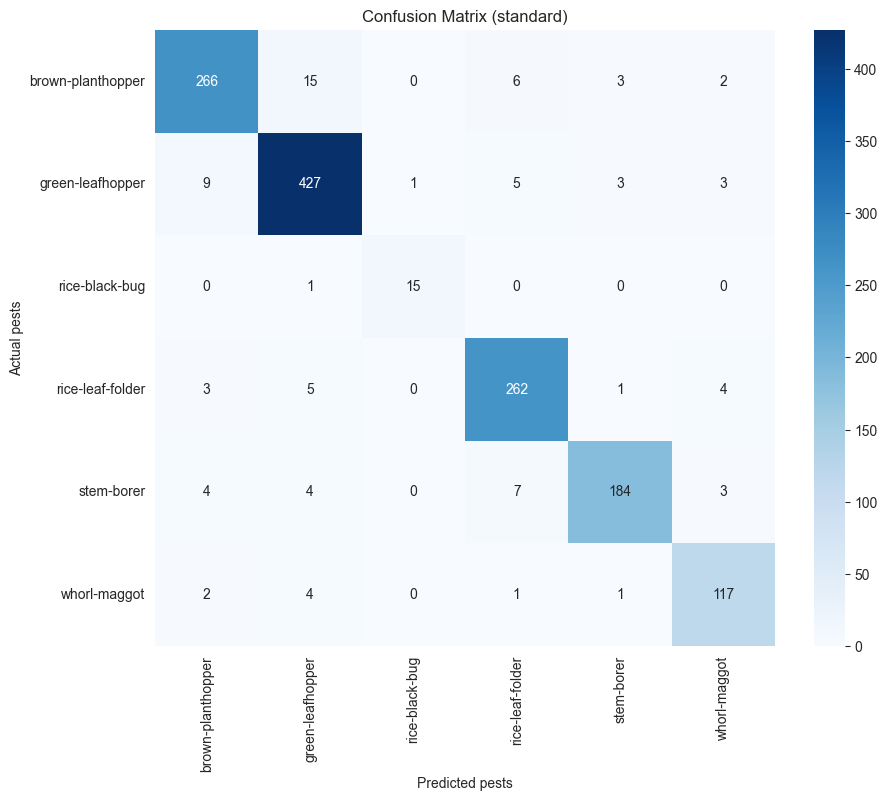

In [21]:
# import mmengine
# from mmengine.logging.history_buffer import HistoryBuffer
#
# torch.serialization.safe_globals([HistoryBuffer])

classes_names = train_set.classes
hardware = torch.device('cuda' if   torch.cuda.is_available() else 'cpu')
model_inference = PestClassifierResNet50(num_classes=len(classes_names))
model_inference.load_state_dict(torch.load('new_models/Resnet50/SResNet50_rice_pest_classificationV3.pt', map_location=hardware))

image_path = 'datasets/test/brown-planthopper/153-0433.png'
unrelated = 'unrelated_data/115-0075.png'

pest, confidence_score, over_all_scores = predict_single_image(model=model_inference, image_path=unrelated, classes=classes_names, transform=validation_pipeline, device=hardware)

print(f"The predicted pest is: {pest}")
print(f"Confidence: {confidence_score * 100:.2f}%")
print(f"Overall score: {over_all_scores}")

true, pred = eval_metrics(model_inference, test_loader, classes_names, hardware)

In [ ]:
import torchvision.models as models

classes_names = train_set.classes
hardware = torch.device('cuda' if   torch.cuda.is_available() else 'cpu')
model_inference = PestClassifierEfficientNetV2M(num_classes=len(classes_names))
model_inference.load_state_dict(torch.load('new_models/EfficientNetV2/SEfficientNetV2-m_rice_pest_classificationV14.pt', map_location=hardware))
image_path = 'datasets/test/brown-planthopper/153-0433.png'
unrelated = 'unrelated_data/115-0075.png'

pest, confidence_score, over_all_scores = predict_single_image(model=model_inference, image_path=image_path, classes=classes_names, transform=validation_pipeline, device=hardware)

print(f"The predicted pest is: {pest}")
print(f"Confidence: {confidence_score * 100:.2f}%")
print(f"Overall score: {over_all_scores}")

true, pred = eval_metrics(model_inference, test_loader, classes_names, hardware)